In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
#!apt-get install keras.layers.core

In [ ]:
import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D,BatchNormalization,Activation
from keras.models import load_model
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.layers import Lambda
from keras import backend as K
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from sklearn import preprocessing


In [ ]:
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [ ]:
#!pip install kerassurgeon

In [ ]:
from kerassurgeon import identify
from kerassurgeon.operations import delete_channels,delete_layer
from kerassurgeon import Surgeon

In [ ]:
def my_get_all_conv_layers(model , first_time):

    '''
    Arguments:
        model -> your model
        first_time -> type boolean
            first_time = True => model is not pruned
            first_time = False => model is pruned
ValueError: Dimensions must be equal, but are 30 and 31 for 'add_65_1/add' (op: 'AddV2') with input shapes: [?,16,16,30], [?,16,16,31].
    Return:
        List of Indices containing convolution layers
    '''

    all_conv_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:6] == 'conv2d'):
            all_conv_layers.append(i)
    return all_conv_layers if (first_time==True) else all_conv_layers[1:]



In [ ]:
def my_get_all_dense_layers(model):
    '''
    Arguments:
        model -> your model
    Return:
        List of Indices containing fully connected layers
    '''
    all_dense_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:5] == 'dense'):
            all_dense_layers.append(i)
    return all_dense_layers

In [ ]:
def count_conv_params_flops(conv_layer):
    # out shape is  n_cells_dim1 * (n_cells_dim2 * n_cells_dim3)
    '''
    Arguments:
        conv layer
    Return:
        Number of Parameters, Number of Flops
    '''


    out_shape = conv_layer.output_shape

    n_cells_total = np.prod(out_shape[1:-1])

    n_conv_params_total = conv_layer.count_params()
    # print(n_conv_params_total,len(conv_layer.get_weights()[0]),)
    conv_flops =  (n_conv_params_total * n_cells_total - len(conv_layer.get_weights()[1]) *n_cells_total)



    return n_conv_params_total, conv_flops


In [ ]:
def count_dense_params_flops(dense_layer):
    # out shape is  n_cells_dim1 * (n_cells_dim2 * n_cells_dim3)
    '''
    Arguments:
      dense layer
    Return:
        Number of Parameters, Number of Flops
    '''

    out_shape = dense_layer.output_shape
    n_cells_total = np.prod(out_shape[1:-1])

    n_dense_params_total = dense_layer.count_params()

    dense_flops =  (n_dense_params_total - len(dense_layer.get_weights()[1]) * n_cells_total)


    return n_dense_params_total, dense_flops


In [ ]:
def count_model_params_flops(model,first_time):

    '''
    Arguments:
        model -> your model
        first_time -> boolean variable
        first_time = True => model is not pruned
        first_time = False => model is pruned
    Return:
        Number of parmaters, Number of Flops
    '''

    total_params = 0
    total_flops = 0
    # if first_time == True:
    #     model_layers = model.layers[:-3]
    # else:
    #     model_layers = model.layers[1:-3]
    model_layers = model.layers
    for index,layer in enumerate(model_layers):
        if any(conv_type in str(type(layer)) for conv_type in ['Conv1D', 'Conv2D', 'Conv3D']):

            params, flops = count_conv_params_flops(layer)
            print(index,layer.name,params,flops)
            total_params += params
            total_flops += flops
        elif 'Dense' in str(type(layer)):

            params, flops = count_dense_params_flops(layer)
            print(index,layer.name,params,flops)
            total_params += params
            total_flops += flops
    return total_params, int(total_flops)


In [ ]:
def my_get_weights_in_conv_layers(model,first_time):

    '''
    Arguments:
        model -> your model
        first_time -> boolean variable
            first_time = True => model is not pruned
            first_time = False => model is pruned
    Return:
        List containing weight tensors of each layer
    '''



    weights = list()
    all_conv_layers = my_get_all_conv_layers(model,first_time)
    layer_wise_weights = list()
    for i in all_conv_layers:
          weights.append(model.layers[i].get_weights()[0])
    return weights

In [ ]:
def my_get_l1_norms_filters_per_epoch(weight_list_per_epoch):

    '''
    Arguments:
        List
    Return:
        Number of parmaters, Number of Flops
    '''

    # weight_list_per_epoch = my_get_weights_in_conv_layers(model,first_time)
    l1_norms_filters_per_epoch = list()


    for index in range(len(weight_list_per_epoch)):

        epochs = np.array(weight_list_per_epoch[index]).shape[0]
        h , w , d = np.array(weight_list_per_epoch[index]).shape[1], np.array(weight_list_per_epoch[index]).shape[2] , np.array(weight_list_per_epoch[index]).shape[3]


        l1_norms_filters_per_epoch.append(np.sum(np.abs(np.array(weight_list_per_epoch[index])).reshape(epochs,h*w*d,-1),axis=1))
    return l1_norms_filters_per_epoch


In [ ]:
def my_in_conv_layers_get_sum_of_l1_norms_sorted_indices(weight_list_per_epoch):
    '''
        Arguments:
            weight List
        Return:

    '''
    layer_wise_filter_sorted_indices = list()
    layer_wise_filter_sorted_values = list()
    l1_norms_filters_per_epoch = my_get_l1_norms_filters_per_epoch(weight_list_per_epoch)
    sum_l1_norms = list()

    for i in l1_norms_filters_per_epoch:
        sum_l1_norms.append(np.sum(i,axis=0))

    layer_wise_filter_sorted_indices = list()

    for i in sum_l1_norms:
        a = pd.Series(i).sort_values().index
        layer_wise_filter_sorted_indices.append(a.tolist())
    return layer_wise_filter_sorted_indices


In [ ]:
def my_get_percent_prune_filter_indices(layer_wise_filter_sorted_indices,percentage):

    prune_filter_indices = list()
    for i in range(len(layer_wise_filter_sorted_indices)):
        prune_filter_indices.append(int(len(layer_wise_filter_sorted_indices[i]) * (percentage/100)))
    return prune_filter_indices

def my_get_distance_matrix(l1_norm_matrix):
    distance_matrix = []
    for i,v1 in enumerate(l1_norm_matrix):
        distance_matrix.append([])
        for v2 in l1_norm_matrix:
            distance_matrix[i].append(np.sum(np.abs((v1-v2))))
    return np.array(distance_matrix)

def my_get_distance_matrix_list(l1_norm_matrix_list):
    distance_matrix_list = []
    for l1_norm_matrix in l1_norm_matrix_list:
        distance_matrix_list.append(my_get_distance_matrix(l1_norm_matrix.T))
    return distance_matrix_list


In [ ]:
def my_get_episodes(distance_matrix,percentage):
    distance_matrix_flatten = pd.Series(distance_matrix.flatten())

    distance_matrix_flatten = distance_matrix_flatten.sort_values().index.to_list()

    episodes = list()
    n = distance_matrix.shape[0]
    for i in distance_matrix_flatten:
        episodes.append((i//n,i%n))
    k = int((n * percentage)/100)
    li = list()
    for i in range(2*k):
        if i%2!=0:
            li.append(episodes[n+i])
    return li


In [ ]:
def my_get_episodes_for_all_layers(distance_matrix_list,percentage):
    all_episodes = list()
    for matrix in distance_matrix_list:
        all_episodes.append(my_get_episodes(matrix,percentage))
    return all_episodes


def my_get_filter_pruning_indices(episodes_for_all_layers,l1_norm_matrix_list):
    filter_pruning_indices = list()
    for layer_index,episode_layer in enumerate(episodes_for_all_layers):
        a = set()
        sum_l1_norms = np.sum(l1_norm_matrix_list[layer_index],axis=0,keepdims=True)

        for episode in episode_layer:
            ep1 = sum_l1_norms.T[episode[0]]
            ep2 = sum_l1_norms.T[episode[1]]
            if ep1 >= ep2:
                a.add(episode[0])
            else:
                a.add(episode[1])
            a.add(episode[0])
        a = list(a)
        filter_pruning_indices.append(a)
    return filter_pruning_indices



In [ ]:

def my_delete_filters(model,weight_list_per_epoch,percentage,first_time,number):
    l1_norms = my_get_l1_norms_filters_per_epoch(weight_list_per_epoch)
    distance_matrix_list = my_get_distance_matrix_list(l1_norms)
    episodes_for_all_layers = my_get_episodes_for_all_layers(distance_matrix_list,percentage)
    filter_pruning_indices = my_get_filter_pruning_indices(episodes_for_all_layers,l1_norms)
    all_conv_layers = my_get_all_conv_layers(model,first_time)
    surgeon = Surgeon(model)
    for index,value in enumerate(all_conv_layers):
        # print(index,value,filter_pruning_indices[index])
        # a = number
        print(len(filter_pruning_indices[index][:a]))
        # while(len(filter_pruning_indices[index][:a]) != a):
        #     a+=1

        surgeon.add_job('delete_channels',model.layers[value],channels = filter_pruning_indices[index][:number])
    model_new = surgeon.operate()


    return model_new


In [ ]:

def my_delete_from_block_1(model,weight_list_per_epoch):
  l1_norms = my_get_l1_norms_filters_per_epoch(weight_list_per_epoch)
  distance_matrix_list = my_get_distance_matrix_list(l1_norms)
  episodes_for_all_layers = my_get_episodes_for_all_layers(distance_matrix_list,90)
  filter_pruning_indices = my_get_filter_pruning_indices(episodes_for_all_layers,l1_norms)[:19]
  all_conv_layers = my_get_all_conv_layers(model,True)[:19]
  surgeon = Surgeon(model)
  for index,value in enumerate(all_conv_layers):
      print(index,value,filter_pruning_indices[index])
      # if len(filter_pruning_indices[index]) > 12  :
      surgeon.add_job('delete_channels',model.layers[value],channels = filter_pruning_indices[index][:2])
  model_new = surgeon.operate()
  return model_new



In [ ]:
def my_delete_from_block_2(model,weight_list_per_epoch):
  l1_norms = my_get_l1_norms_filters_per_epoch(weight_list_per_epoch)
  distance_matrix_list = my_get_distance_matrix_list(l1_norms)
  episodes_for_all_layers = my_get_episodes_for_all_layers(distance_matrix_list,90)
  filter_pruning_indices = my_get_filter_pruning_indices(episodes_for_all_layers,l1_norms)[19:38]
  all_conv_layers = my_get_all_conv_layers(model,True)[19:38]
  surgeon = Surgeon(model)
  for index,value in enumerate(all_conv_layers):
      print(index,value,filter_pruning_indices[index])
      # if len(filter_pruning_indices[index]) > 12  :
      surgeon.add_job('delete_channels',model.layers[value],channels = filter_pruning_indices[index][:4])
  model_new = surgeon.operate()
  return model_new



In [ ]:

def my_delete_from_block_3(model,weight_list_per_epoch):
  l1_norms = my_get_l1_norms_filters_per_epoch(weight_list_per_epoch)
  distance_matrix_list = my_get_distance_matrix_list(l1_norms)
  episodes_for_all_layers = my_get_episodes_for_all_layers(distance_matrix_list,90)
  filter_pruning_indices = my_get_filter_pruning_indices(episodes_for_all_layers,l1_norms)[38:]
  all_conv_layers = my_get_all_conv_layers(model,True)[38:]
  surgeon = Surgeon(model)
  for index,value in enumerate(all_conv_layers):
      print(index,value,filter_pruning_indices[index])
      surgeon.add_job('delete_channels',model.layers[value],channels = filter_pruning_indices[index][:8])
  model_new = surgeon.operate()
  return model_new


In [ ]:
class Get_Weights(Callback):
    def __init__(self,first_time):
        super(Get_Weights, self).__init__()
        self.weight_list = [] #Using a list of list to store weight tensors per epoch
        self.first_time = first_time
    def on_epoch_end(self,epoch,logs=None):
        if epoch == 0:
            all_conv_layers = my_get_all_conv_layers(self.model,self.first_time)
            for i in range(len(all_conv_layers)):
                self.weight_list.append([]) # appending empty lists for later appending weight tensors

        for index,each_weight in enumerate(my_get_weights_in_conv_layers(self.model,self.first_time)):
                self.weight_list[index].append(each_weight)


In [ ]:
batch_size = 512  # orig paper trained all networks with batch_size=128
epochs = 10
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


170498071/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [ ]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])

# model = load_model('./before_resnet.h5')
# a = model.evaluate(x_test,y_test)
# print(a)
# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(learning_rate=lr_schedule(0)),
#               metrics=['accuracy'])


#Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
gw = Get_Weights(True)
callbacks = [checkpoint, lr_reducer, lr_scheduler,gw]

# Run training, with or without data augmentation.

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)



Learning rate:  0.001
Using real-time data augmentation.


In [ ]:

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# # Fit the model on the batches generated by datagen.flow().
history  = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

weight_list_per_epoch = gw.weight_list


<ipython-input-30-f37dcc5790f4>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history  = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Learning rate:  0.001
Epoch 1/10
98/98 [==============================] - ETA: 0s - loss: 1.8079 - accuracy: 0.3985

98/98 [==============================] - 54s 374ms/step - loss: 1.8079 - accuracy: 0.3985 - val_loss: 3.3894 - val_accuracy: 0.1621 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 1.4207 - accuracy: 0.5405

98/98 [==============================] - 36s 356ms/step - loss: 1.4207 - accuracy: 0.5405 - val_loss: 2.5152 - val_accuracy: 0.3005 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 1.2565 - accuracy: 0.6032

98/98 [==============================] - 35s 344ms/step - loss: 1.2565 - accuracy: 0.6032 - val_loss: 1.7456 - val_accuracy: 0.4718 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 1.1529 - accuracy: 0.6444

98/98 [==============================] - 35s 342ms/step - loss: 1.1529 - accuracy: 0.6444 - val_loss: 1.5775 - val_accuracy: 0.5295 - lr: 0.0010
Learning rate:  0.001
Epoch 5/10
98/98 [==============================] - ETA: 0s - loss: 1.0609 - accuracy: 0.6739

98/98 [==============================] - 36s 345ms/step - loss: 1.0609 - accuracy: 0.6739 - val_loss: 1.4140 - val_accuracy: 0.5930 - lr: 0.0010
Learning rate:  0.001
Epoch 6/10
98/98 [==============================] - ETA: 0s - loss: 0.9880 - accuracy: 0.7014

98/98 [==============================] - 35s 353ms/step - loss: 0.9880 - accuracy: 0.7014 - val_loss: 1.1135 - val_accuracy: 0.6611 - lr: 0.0010
Learning rate:  0.001
Epoch 7/10
98/98 [==============================] - ETA: 0s - loss: 0.9260 - accuracy: 0.7238

98/98 [==============================] - 35s 352ms/step - loss: 0.9260 - accuracy: 0.7238 - val_loss: 1.2578 - val_accuracy: 0.6342 - lr: 0.0010
Learning rate:  0.001
Epoch 8/10
98/98 [==============================] - ETA: 0s - loss: 0.8714 - accuracy: 0.7441

98/98 [==============================] - 35s 345ms/step - loss: 0.8714 - accuracy: 0.7441 - val_loss: 1.0690 - val_accuracy: 0.6791 - lr: 0.0010
Learning rate:  0.001
Epoch 9/10
98/98 [==============================] - ETA: 0s - loss: 0.8347 - accuracy: 0.7563

98/98 [==============================] - 35s 349ms/step - loss: 0.8347 - accuracy: 0.7563 - val_loss: 1.0150 - val_accuracy: 0.7044 - lr: 0.0010
Learning rate:  0.001
Epoch 10/10
98/98 [==============================] - ETA: 0s - loss: 0.7937 - accuracy: 0.7710

98/98 [==============================] - 36s 351ms/step - loss: 0.7937 - accuracy: 0.7710 - val_loss: 0.9347 - val_accuracy: 0.7353 - lr: 0.0010


In [ ]:
def train(model,epochs):
    gw = Get_Weights(True)
    callbacks = [lr_reducer, lr_scheduler,gw]
    model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=lr_schedule(0)),
                metrics=['accuracy'])

    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)
    return model,gw.weight_list,history

In [ ]:
from keras import backend as K

def custom_loss(lmbda , regularizer_value):
  def loss(y_true , y_pred):
    # print(type(K.categorical_crossentropy(y_true ,y_pred)),K.categorical_crossentropy(y_true ,y_pred),regularizer_value)
    return K.categorical_crossentropy(y_true ,y_pred) + lmbda * regularizer_value
  return loss

In [ ]:
def my_get_l1_norms_filters(model,first_time):
    conv_layers = my_get_all_conv_layers(model,first_time)
    l1_norms = list()
    for index,layer_index in enumerate(conv_layers):
        l1_norms.append([])
        # print(layer_index)
        weights = model.layers[layer_index].get_weights()[0]
        num_filters = len(weights[0,0,0,:])
        for i in range(num_filters):
            weights_sum = np.sum(abs(weights[:,:,:,i]))
            l1_norms[index].append(weights_sum)
    print(l1_norms)
    return l1_norms

In [ ]:
def my_get_regularizer_value(model,weight_list_per_epoch,percentage,first_time):
    l1_norms_per_epoch = my_get_l1_norms_filters_per_epoch(weight_list_per_epoch)
    distance_matrix_list = my_get_distance_matrix_list(l1_norms_per_epoch)
    episodes_for_all_layers = my_get_episodes_for_all_layers(distance_matrix_list,percentage)
    l1_norms = my_get_l1_norms_filters(model,first_time)
    print(episodes_for_all_layers)
    regularizer_value = 0
    for layer_index,layer in enumerate(episodes_for_all_layers):
        for episode in layer:
            # print(episode[1],episode[0])
            regularizer_value += abs(l1_norms[layer_index][episode[1]] - l1_norms[layer_index][episode[0]])
    regularizer_value = np.exp(-0.001*(regularizer_value))
    return regularizer_value


In [ ]:
def optimize(model,weight_list_per_epoch,epochs,percentage):
    callbacks = [lr_reducer, lr_scheduler]
    regularizer_value = my_get_regularizer_value(model,weight_list_per_epoch,percentage,True)
    model_loss = custom_loss(1,regularizer_value)
    print("INITIAL REGULARIZER VALUE ",my_get_regularizer_value(model,weight_list_per_epoch,percentage,True))

    model.compile(loss=model_loss,
                optimizer=Adam(learning_rate=lr_schedule(0)),
                metrics=['accuracy'])

    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)
    print("FINAL REGULARIZER VALUE ",my_get_regularizer_value(model,weight_list_per_epoch,percentage,True))

    return model,history

In [ ]:
#this dictionary is to log the parameters and is later converted into a dataframe.
log_dict = dict()
log_dict['train_loss'] = []
log_dict['train_acc'] = []
log_dict['val_loss'] = []
log_dict['val_acc'] = []
log_dict['total_params'] = []
log_dict['total_flops'] = []


best_acc_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
log_dict['train_loss'].append(history.history['loss'][best_acc_index])
log_dict['train_acc'].append(history.history['accuracy'][best_acc_index])
log_dict['val_loss'].append(history.history['val_loss'][best_acc_index])
log_dict['val_acc'].append(history.history['val_accuracy'][best_acc_index])
validation_accuracy = max(history.history['val_accuracy'])

log_dict['remaining_filters'] = []
a,b = count_model_params_flops(model,True)
log_dict['total_params'].append(a)
log_dict['total_flops'].append(b)
x = (my_get_weights_in_conv_layers(model,True))
remaining_filters = []
for i in x:
  remaining_filters.append(i.shape[3])
log_dict['remaining_filters'].append(remaining_filters)

log_df = pd.DataFrame(log_dict)
log_df.to_csv('/content/drive/MyDrive/ML/resnet_OPT_4.csv')
print("Initial Validation Accuracy = {}".format(validation_accuracy) )
max_val_acc = validation_accuracy
count = 0
model.save('/content/drive/MyDrive/ML/')
# while validation_accuracy - max_val_acc >= -0.02 and count < 4 :

#     print("ITERATION {} ".format(count+1))

#     if max_val_acc < validation_accuracy:
#         max_val_acc = validation_accuracy

#     model,_ = optimize(model,weight_list_per_epoch,10,10)
#     model = my_delete_from_block_1(model,weight_list_per_epoch)
#     model =  my_delete_from_block_2(model,weight_list_per_epoch)
#     model = my_delete_from_block_3(model,weight_list_per_epoch)
#     model,weight_list_per_epoch,history = train(model,200)


#     a,b = count_model_params_flops(model,False)


#     validation_accuracy = max(history.history['val_accuracy'])
#     best_acc_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
#     log_dict['train_loss'].append(history.history['loss'][best_acc_index])
#     log_dict['train_acc'].append(history.history['accuracy'][best_acc_index])
#     log_dict['val_loss'].append(history.history['val_loss'][best_acc_index])
#     log_dict['val_acc'].append(history.history['val_accuracy'][best_acc_index])
#     log_dict['total_params'].append(a)
#     log_dict['total_flops'].append(b)
#     x = (my_get_weights_in_conv_layers(model,True))
#     remaining_filters = []
#     for i in x:
#       remaining_filters.append(i.shape[3])
#     log_dict['remaining_filters'].append(remaining_filters)

#     log_df = pd.DataFrame(log_dict)
#     log_df.to_csv('/')

#     print("VALIDATION ACCURACY AFTER {} ITERATIONS = {}".format(count+1,validation_accuracy))
#     count+=1
#     model.save('/')

1 conv2d 448 442368
4 conv2d_1 2320 2359296
7 conv2d_2 2320 2359296
11 conv2d_3 2320 2359296
14 conv2d_4 2320 2359296
18 conv2d_5 2320 2359296
21 conv2d_6 2320 2359296
25 conv2d_7 4640 1179648
28 conv2d_8 9248 2359296
29 conv2d_9 544 131072
33 conv2d_10 9248 2359296
36 conv2d_11 9248 2359296
40 conv2d_12 9248 2359296
43 conv2d_13 9248 2359296
47 conv2d_14 18496 1179648
50 conv2d_15 36928 2359296
51 conv2d_16 2112 131072
55 conv2d_17 36928 2359296
58 conv2d_18 36928 2359296
62 conv2d_19 36928 2359296
65 conv2d_20 36928 2359296
71 dense 650 640.0
Initial Validation Accuracy = 0.7353000044822693


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
log_dict['total_flops']# Print training and validation metrics
print("Training Loss:", log_dict['train_loss'])
print("Training Accuracy:", log_dict['train_acc'])
print("Validation Loss:", log_dict['val_loss'])
print("Validation Accuracy:", log_dict['val_acc'])


Training Loss: [0.7936816215515137]
Training Accuracy: [0.7709800004959106]
Validation Loss: [0.9347435832023621]
Validation Accuracy: [0.7353000044822693]


In [ ]:
# Print model parameters and complexity
print("Total Parameters:", log_dict['total_params'])
print("Total FLOPs:", log_dict['total_flops'])

Total Parameters: [271690]
Total FLOPs: [40813184]


In [ ]:
# Print remaining filters after pruning
print("Remaining Filters:", log_dict['remaining_filters'])


Remaining Filters: [[16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64, 64]]


In [ ]:
epoch = 10  # Replace 10 with the actual epoch number you want to print

# Print learning rate schedule with the defined epoch
print("Learning Rate:", lr_schedule(epoch))


Learning rate:  0.001
Learning Rate: 0.001


In [ ]:
# Print iteration count and convergence
print("Iteration Count:", count)
print("Validation Accuracy after Iterations:", validation_accuracy)

Iteration Count: 0
Validation Accuracy after Iterations: 0.7353000044822693


In [ ]:
print(log_df)

   train_loss  train_acc  val_loss  val_acc  total_params  total_flops  \
0    0.793682    0.77098  0.934744   0.7353        271690     40813184   

                                   remaining_filters  
0  [16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 3...  


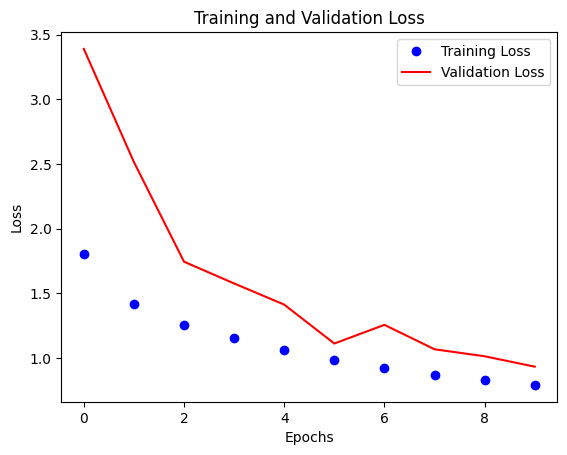

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a History object named history from model.fit
# history = model.fit(...)

# Plotting training and validation loss
plt.plot(history.epoch, history.history['loss'], 'bo', label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np

def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity


In [ ]:
def calculate_cosine_similarity(model, layer_index, epochs=10):
    similarity_values = []

    # Get the layer weights for the specified layer index
    layer_weights = model.layers[layer_index].get_weights()[0]

    for epoch in range(epochs):
        # Train the model for one epoch
        history = model.fit(...)  # You need to replace ... with actual training data

        # Get the updated layer weights after training
        updated_layer_weights = model.layers[layer_index].get_weights()[0]

        # Calculate cosine similarity for every pair of filters
        for i in range(layer_weights.shape[3]):
            for j in range(i + 1, layer_weights.shape[3]):
                filter1 = layer_weights[:, :, :, i].flatten()
                filter2 = layer_weights[:, :, :, j].flatten()
                similarity = cosine_similarity(filter1, filter2)
                similarity_values.append(similarity)

        # Update the original layer weights with the updated weights for the next epoch
        layer_weights = updated_layer_weights

    return similarity_values


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(model, layer_index, x_train, y_train, epochs=10):
    similarity_values = []

    # Get the layer weights for the specified layer index
    layer_weights = model.layers[layer_index].get_weights()[0]

    for epoch in range(epochs):
        # Train the model for one epoch using actual data
        history = model.fit(x_train, y_train, epochs=1, verbose=0)

        # Get the updated layer weights after training
        updated_layer_weights = model.layers[layer_index].get_weights()[0]

        # Calculate cosine similarity for every pair of filters
        for i in range(layer_weights.shape[3]):
            for j in range(i + 1, layer_weights.shape[3]):
                filter1 = layer_weights[:, :, :, i].flatten()
                filter2 = layer_weights[:, :, :, j].flatten()
                similarity = cosine_similarity([filter1], [filter2])[0][0]
                similarity_values.append(similarity)

        # Update the original layer weights with the updated weights for the next epoch
        layer_weights = updated_layer_weights

    return similarity_values


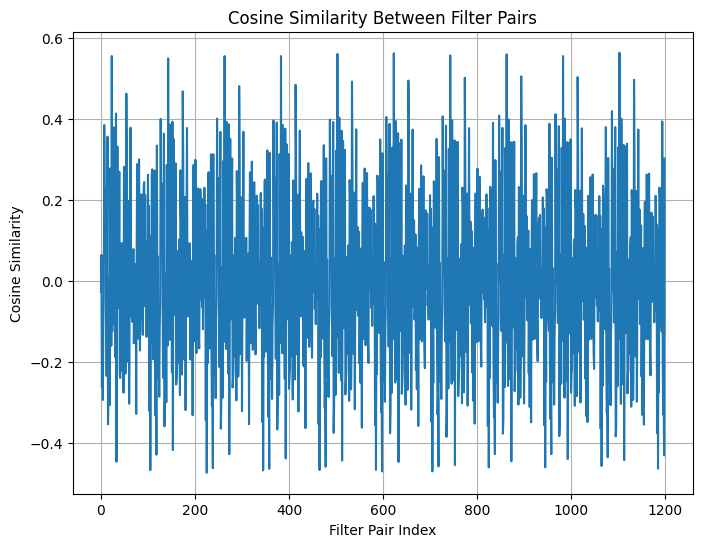

In [ ]:


# Specify the layer index for which you want to calculate cosine similarity
layer_index = 1  # Assuming the Conv2D layer is the second layer (index 1) in the model

# Calculate cosine similarity over 10 epochs
similarity_values = calculate_cosine_similarity(model, layer_index, x_train, y_train, epochs=10)

# Plot the similarity values
plt.figure(figsize=(8, 6))
plt.plot(similarity_values)
plt.xlabel('Filter Pair Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Between Filter Pairs')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity
def calculate_cosine_similarity(model, layer_index, x_train, y_train, epochs=10):
    similarity_values = []

    # Get the layer weights for the specified layer index
    layer_weights = model.layers[layer_index].get_weights()[0]

    for epoch in range(epochs):
        # Train the model for one epoch using actual data
        history = model.fit(x_train, y_train, epochs=1, verbose=0)

        # Get the updated layer weights after training
        updated_layer_weights = model.layers[layer_index].get_weights()[0]

        # Calculate cosine similarity for every pair of filters
        for i in range(layer_weights.shape[3]):
            for j in range(i + 1, layer_weights.shape[3]):
                filter1 = layer_weights[:, :, :, i].flatten()
                filter2 = layer_weights[:, :, :, j].flatten()
                similarity = cosine_similarity([filter1], [filter2])[0][0]
                similarity_values.append((i, j, similarity))  # Store filter indices and similarity value

        # Update the original layer weights with the updated weights for the next epoch
        layer_weights = updated_layer_weights

    return similarity_values

# Function to prune similar filters
def prune_similar_filters(similarity_values, threshold):
    similar_pairs = []
    pruned_filters = set()

    # Identify similar filter pairs based on threshold
    for i, j, similarity in similarity_values:
        if similarity >= threshold:
            similar_pairs.append((i, j))

    # Prune one filter from each similar pair
    for i, j in similar_pairs:
        if i not in pruned_filters and j not in pruned_filters:
            pruned_filters.add(j)  # Add the index of the filter to prune

    return pruned_filters

# # Load the trained model
# model = load_model('path_to_your_trained_model.h5')

# # Load or generate your training data
# x_train = ...  # Actual training input data (numpy array)
# y_train = ...  # Actual training labels (numpy array)

# Specify the layer index for which you want to calculate cosine similarity
layer_index = 1  # Assuming the Conv2D layer is the second layer (index 1) in the model

# Calculate cosine similarity over 10 epochs
print("Calculating cosine similarity...")
similarity_values = calculate_cosine_similarity(model, layer_index, x_train, y_train, epochs=10)

# Specify the threshold for similarity
threshold = 0.95  # Adjust the threshold as needed

# Prune similar filters based on cosine similarity
pruned_filters = prune_similar_filters(similarity_values, threshold)
print("Pruned Filters:", pruned_filters)

# Further code to prune the filters from the model using the filter indices in pruned_filters
# You can use a function like my_delete_filters to prune the filters from the model

# Example:
# model_new = my_delete_filters(model, pruned_filters)

# Save the pruned model
# model_new.save('path_to_pruned_model.h5')

# Print training and validation metrics
print("Training Loss:", history.history['loss'])
print("Training Accuracy:", history.history['accuracy'])
print("Validation Loss:", history.history['val_loss'])
print("Validation Accuracy:", history.history['val_accuracy'])

# Print model parameters and complexity
total_params = model.count_params()
total_flops = ...  # Calculate total FLOPs based on model architecture

print("Total Parameters:", total_params)
print("Total FLOPs:", total_flops)

# Print remaining number of filters after pruning
remaining_filters = model.layers[layer_index].filters - len(pruned_filters)
print("Remaining Filters:", remaining_filters)

# # Print regularization value (assuming it's stored in a variable named regularization_value)
# print("Regularization Value:", regularization_value)

# # Print learning rate schedule (assuming it's stored in a variable named lr_schedule)
# print("Learning Rate:", lr_schedule(epoch))

# # Print iteration count and convergence (assuming iteration count is stored in a variable named iteration_count)
# print("Iteration Count:", iteration_count)
# print("Validation Accuracy at each Iteration:", validation_accuracy_list)

# Export DataFrame to CSV
log_dict = {
    'train_loss': history.history['loss'],
    'train_acc': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_acc': history.history['val_accuracy'],
    'total_params': total_params,
    'total_flops': total_flops,
    'remaining_filters': remaining_filters,
    # 'regularization_value': regularization_value,
    # 'learning_rate': lr_schedule(epoch),
    # 'iteration_count': iteration_count,
    # 'validation_accuracy_list': validation_accuracy_list
}

log_df = pd.DataFrame(log_dict)
log_df.to_csv('/content/drive/MyDrive/ML/path_to_log_file.csv')


Calculating cosine similarity...
Pruned Filters: set()
Training Loss: [1.807948112487793, 1.4206560850143433, 1.2565022706985474, 1.1528605222702026, 1.0609005689620972, 0.987966001033783, 0.9260185956954956, 0.8713622093200684, 0.8346614837646484, 0.7936816215515137]
Training Accuracy: [0.3984600007534027, 0.5405399799346924, 0.6032400131225586, 0.6443799734115601, 0.6739400029182434, 0.7014399766921997, 0.7238399982452393, 0.7441200017929077, 0.7562599778175354, 0.7709800004959106]
Validation Loss: [3.3893871307373047, 2.5152318477630615, 1.7455531358718872, 1.5775021314620972, 1.4139752388000488, 1.113532543182373, 1.257812738418579, 1.0690277814865112, 1.0150189399719238, 0.9347435832023621]
Validation Accuracy: [0.16210000216960907, 0.3005000054836273, 0.4717999994754791, 0.5295000076293945, 0.5929999947547913, 0.6610999703407288, 0.6341999769210815, 0.679099977016449, 0.7044000029563904, 0.7353000044822693]
Total Parameters: 274442
Total FLOPs: Ellipsis
Remaining Filters: 16


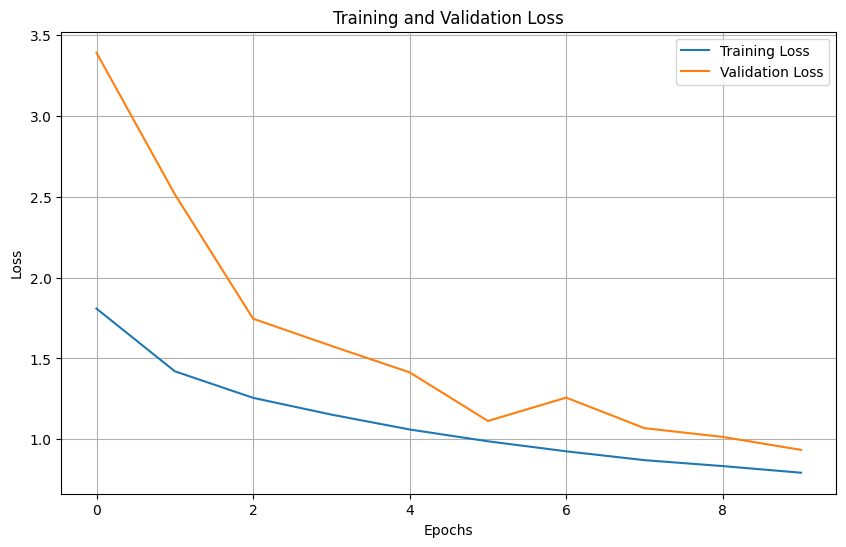

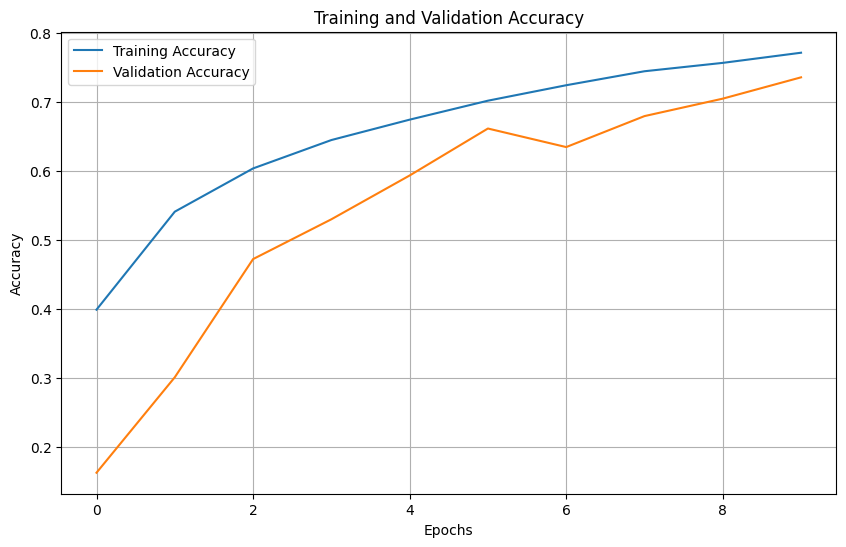

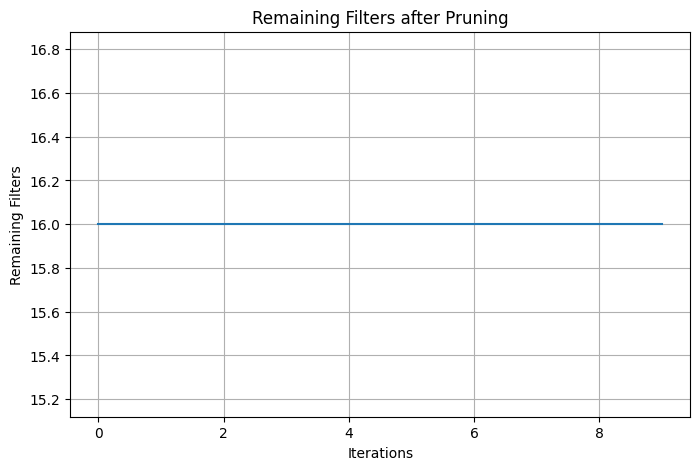

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# # Load the log dataframe from the CSV file
# log_df = pd.read_csv('path_to_log_file.csv')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(log_df['train_loss'], label='Training Loss')
plt.plot(log_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(log_df['train_acc'], label='Training Accuracy')
plt.plot(log_df['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot remaining filters after pruning
plt.figure(figsize=(8, 5))
plt.plot(log_df['remaining_filters'])
plt.xlabel('Iterations')
plt.ylabel('Remaining Filters')
plt.title('Remaining Filters after Pruning')
plt.grid(True)
plt.show()

